In [298]:
import setigen as stg
import bifrost as bf
from bifrost.fdmt import Fdmt
import numpy as np
import blimpy as bl
import matplotlib.pyplot as plt
from astropy import units as u

fdmt= Fdmt()

In [299]:
%matplotlib inline

**Creating the Frame**

6095000001.0 6094998977.0
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290.]


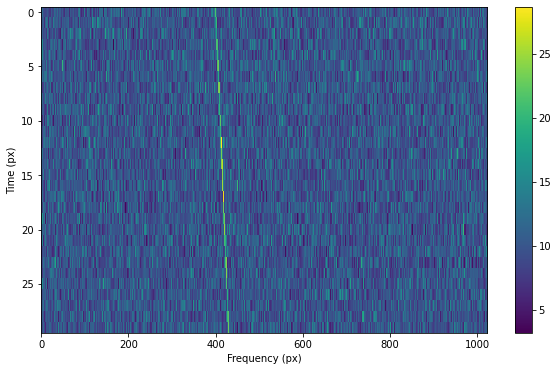

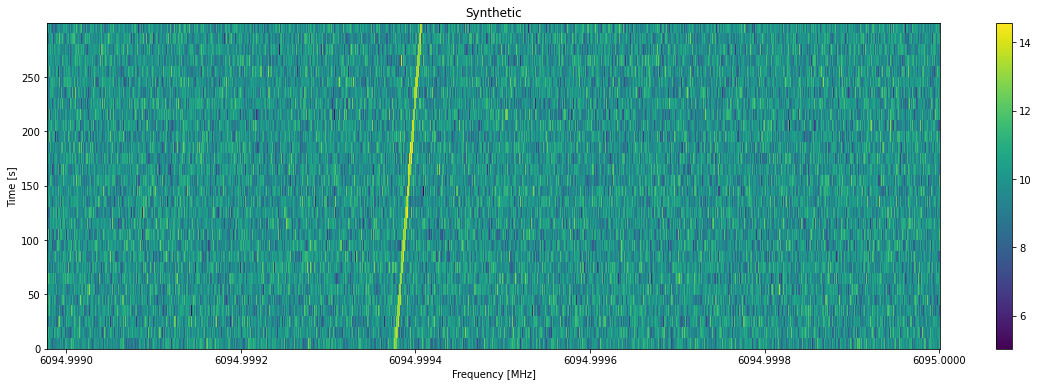

In [311]:
from astropy import units as u
import setigen as stg
import matplotlib.pyplot as plt

frame = stg.Frame(fchans=1024*u.pixel,
                  tchans=30*u.pixel,
                  df=df*u.Hz,
                  dt=dt*u.s,
                  fch1=6095*u.MHz)
noise = frame.add_noise(x_mean=10, noise_type='chi2')
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=400),
                                            drift_rate=frame.df/frame.dt),
                          stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                          stg.box_f_profile(width=4*u.Hz),
                          stg.constant_bp_profile(level=1))

print(frame.get_frequency(1024),frame.get_frequency(0))
print(frame.ts)
fig = plt.figure(figsize=(10, 6))
frame.plot()
plt.show()

fig = plt.figure(figsize=(20, 6))
frame.bl_plot()
plt.show()

**Defining the FDMT function to run on the frame**

In [312]:
def ddframe(stgframe, max_delay, negative_delays, exponent):
    
    fr=stgframe
    
    gulp_size = 4 * 8192

    d_cpu = np.expand_dims(fr.data, axis=0) + 0.1
    print(d_cpu.shape)

    ## Initialize FDMT
    n_disp = max_delay
    n_time = d_cpu.shape[2]
    n_chan = d_cpu.shape[1]
    fdmt.init(n_chan, n_disp, fr.fch1, fr.df, space="cuda", exponent=exponent)


    # Input shape is (1, n_freq, n_time)
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')

    # Execute FDMT
    fdmt.execute(d_in, d_out, negative_delays=negative_delays)

    d_out = d_out.copy(space='system')
  
    #plotting the fdmt
    plt.figure(figsize=(9, 6))
    plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto', extent=[0, fr.fchans, ((max_delay/fr.tchans)*(fr.df/fr.dt)), 0])
    
    plt.xlabel("Frequency Channel")
    plt.ylabel("Dispersion trial (Hz/s)")
    plt.colorbar()
    

(1, 30, 1024)


/tmp/ipykernel_7677/3547227442.py:28: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto', extent=[0, fr.fchans, ((max_delay/fr.tchans)*(fr.df/fr.dt)), 0])


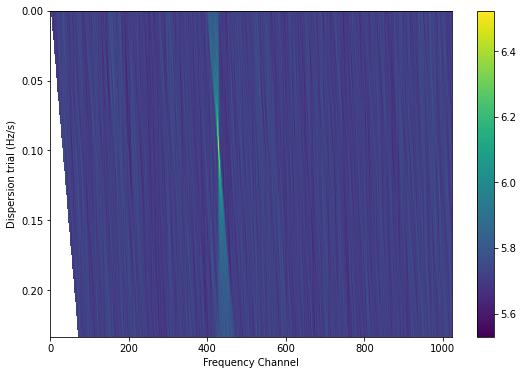

In [325]:
ddframe(frame, 70, True, 1)

In [314]:
def ddframecentered(stgframe, negative_delays, exponent):
    
    fr=stgframe
    drift_rate=fr.df/fr.dt
    frequency = fr.dt*fr.tchans*drift_rate
    max_delay=int(frequency*2)
    print(max_delay)
    #max_delay = max_drift_rate
    gulp_size = 4 * 8192

    d_cpu = np.expand_dims(fr.data, axis=0) + 0.1
    print(d_cpu.shape)

    ## Initialize FDMT
    n_disp = max_delay
    n_time = d_cpu.shape[2]
    n_chan = d_cpu.shape[1]
    fdmt.init(n_chan, n_disp, fr.fch1, fr.df, space="cuda", exponent=exponent)


    # Input shape is (1, n_freq, n_time)
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')

    # Execute FDMT
    fdmt.execute(d_in, d_out, negative_delays=True)
    d_out = d_out.copy(space='system')
    
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out2 = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')
    
    fdmt.execute(d_in, d_out2, negative_delays=False)
    d_out2 = d_out2.copy(space='system')
    
    fal=np.array(d_out2)
    fal=np.flip(fal, axis=1)
    #plotting the fdmt
    plt.figure(figsize=(9, 6))
    plt.imshow(np.log(np.concatenate((fal,np.array(d_out)), axis=1).squeeze()), aspect='auto', extent=[0, fr.fchans, -((max_delay/fr.tchans)*(fr.df/fr.dt)), ((max_delay/fr.tchans)*(fr.df/fr.dt))])
    #, extent=[0, 1024, 0.23, 0]
    plt.xlabel("Frequency")
    plt.ylabel("Dispersion trial")
    plt.colorbar()
    

**Running fdmt on frame**

60
(1, 30, 1024)


/tmp/ipykernel_7677/957089790.py:39: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.concatenate((fal,np.array(d_out)), axis=1).squeeze()), aspect='auto', extent=[0, fr.fchans, -((max_delay/fr.tchans)*(fr.df/fr.dt)), ((max_delay/fr.tchans)*(fr.df/fr.dt))])


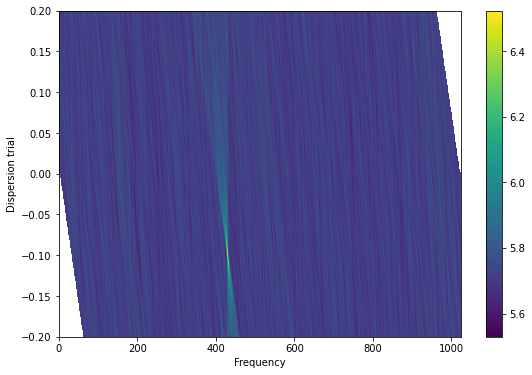

In [315]:
ddframecentered(frame, True, 1)

**Running Hyperseti on frame**

In [316]:
import hyperseti
from hyperseti import dedoppler
from hyperseti import plotting 

In [317]:
test_data = np.expand_dims(frame.data.astype('float32'), axis=1)

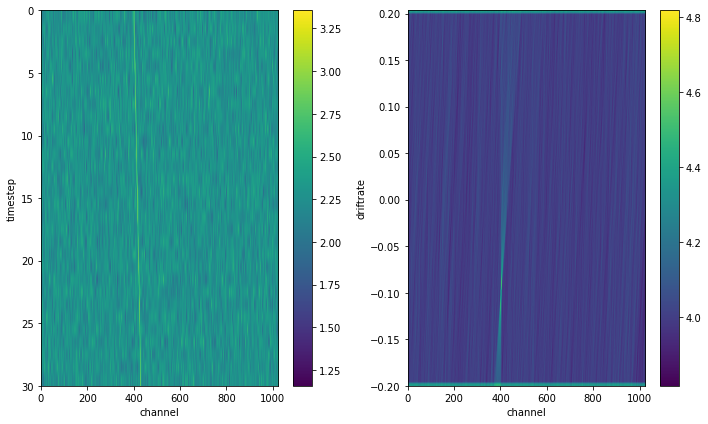

In [321]:
metadata = {'frequency_start': frame.get_frequency(index=400)*u.MHz, 'time_step': 10*u.s, 'frequency_step': 1*u.Hz}

# Run dedoppler
dedopp, metadata= dedoppler(test_data, metadata, boxcar_size=1, max_dd=0.2)

# Imshow output
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plotting.imshow_waterfall(np.log(test_data), metadata)
plt.subplot(1,2,2)
plotting.imshow_dedopp(np.log(dedopp), metadata)
plt.tight_layout()

**Running TurboSETI on Frame.h5**

In [206]:
frame.save_h5(filename='Frame.h5')

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for Frame.h5 without blobbing.
blimpy.waterfall INFO     Conversion time: 0.02sec


In [207]:
import time
from blimpy import Waterfall
from turbo_seti.find_doppler.find_doppler import FindDoppler

H5DIR = "/datax2/users/icrar2021/cho134/fdmt-test/TurboSETI/"
H5PATH = H5DIR + "Frame.h5"
OUT_DIR_BASE = H5DIR

print("\nUsing HDF5 file: {}\nHeader and data shape:".format(H5PATH))
# -- Get a report of header and data shape
wf = Waterfall(H5PATH)
#wf.header['foff'] = 1e-6
wf.info()
# -- Instantiate FindDoppler.
print("\nInstantiating the FindDoppler object.")
fdop = FindDoppler(datafile=H5PATH, max_drift=4, snr=30, out_dir=H5DIR, n_coarse_chan=1)
# -- Search for hits and report elapsed time.
print("\nBegin doppler search.  Please wait ...")
t1 = time.time()
fdop.search()
elapsed_time = time.time() - t1
print("\nFindDoppler.search() elapsed time = {} seconds".format(elapsed_time))


Using HDF5 file: /datax2/users/icrar2021/cho134/fdmt-test/TurboSETI/Frame.h5
Header and data shape:

--- File Info ---
DIMENSION_LABELS :   ['time' 'feed_id' 'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :                       6095.0 MHz
            foff :                       -1e-06 MHz
           ibeam :                               -1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                             1024
            nifs :                                1
     rawdatafile :                        Synthetic
     source_name :                        Synthetic
         src_dej :                     -28:22:59.16
         src_raj :                         17:47:15
    telescope_id :                                6
           tsamp :                             1